In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.keras.layers as layers
import cv2
import os
import statistics
import skimage

2023-07-24 14:30:32.385770: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-24 14:30:32.632375: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-24 14:30:32.740804: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-07-24 14:30:36.126720: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [15]:
"""Slot Attention model for object discovery and set prediction."""

class SlotAttention(layers.Layer):
  """Slot Attention module."""

  def __init__(self, num_iterations, num_slots, slot_size, mlp_hidden_size,
               epsilon=1e-8):
    """Builds the Slot Attention module.
    Args:
      num_iterations: Number of iterations.
      num_slots: Number of slots.
      slot_size: Dimensionality of slot feature vectors.
      mlp_hidden_size: Hidden layer size of MLP.
      epsilon: Offset for attention coefficients before normalization.
    """
    super().__init__()
    self.num_iterations = num_iterations
    self.num_slots = num_slots
    self.slot_size = slot_size
    self.mlp_hidden_size = mlp_hidden_size
    self.epsilon = epsilon

    self.norm_inputs = layers.LayerNormalization()
    self.norm_slots = layers.LayerNormalization()
    self.norm_mlp = layers.LayerNormalization()
    
    
    # Parameters for Gaussian init (shared by all slots).   # Intialize slots randomly at first 
    self.slots_mu = self.add_weight(
        initializer="glorot_uniform",
        shape=[1, 1, self.slot_size],   # slot_size: Dimensionality of slot feature vectors.
        dtype=tf.float32,
        name="slots_mu")
    self.slots_log_sigma = self.add_weight(
        initializer="glorot_uniform",
        shape=[1, 1, self.slot_size],
        dtype=tf.float32,
        name="slots_log_sigma")
    
    
    # Linear maps for the attention module.
    self.project_q = layers.Dense(self.slot_size, use_bias=False, name="q")
    self.project_k = layers.Dense(self.slot_size, use_bias=False, name="k")
    self.project_v = layers.Dense(self.slot_size, use_bias=False, name="v")

    # Slot update functions.
    self.gru = layers.GRUCell(self.slot_size)
    
    self.mlp = tf.keras.Sequential([ 
        layers.Dense(self.mlp_hidden_size, activation="relu"),
        layers.Dense(self.slot_size)
    ], name="mlp")
    

  def call(self, inputs):
    # `inputs` has shape [batch_size, num_inputs, inputs_size].
    inputs = self.norm_inputs(inputs)  # Apply layer norm to the input.
    k = self.project_k(inputs)  # Shape: [batch_size, num_inputs, slot_size].  # create key vectors (based on inputs)
    v = self.project_v(inputs)  # Shape: [batch_size, num_inputs, slot_size].  # create value vectors (based on inputs)

    # Initialize the slots. Shape: [batch_size, num_slots, slot_size].
    slots = self.slots_mu + tf.exp(self.slots_log_sigma) * tf.random.normal(
        [tf.shape(inputs)[0], self.num_slots, self.slot_size])  # size: [batch_size, num_slots, slot_size]

    # slots = tf.random.normal([tf.shape(inputs)[0], self.num_slots, self.slot_size]) # size: [batch_size, num_slots, slot_size]
    
    # Multiple rounds of attention.
    for _ in range(self.num_iterations):
      slots_prev = slots
      slots = self.norm_slots(slots)

      # Attention.
      q = self.project_q(slots)  # Shape: [batch_size, num_slots, slot_size].  # create query vectors (based on slots)
      q *= self.slot_size ** -0.5  # Normalization.
      attn_logits = tf.keras.backend.batch_dot(k, q, axes=-1) # Batchwise dot product.
      attn = tf.nn.softmax(attn_logits, axis=-1)
      # `attn` has shape: [batch_size, num_inputs, num_slots]. 
      # attn represents how much attention each slot should pay to the features 

      # Weigted mean.
      attn += self.epsilon
      attn /= tf.reduce_sum(attn, axis=-2, keepdims=True) # summation; sum across the batch_size 
      updates = tf.keras.backend.batch_dot(attn, v, axes=-2)
      # `updates` has shape: [batch_size, num_slots, slot_size].

      # Slot update.
      slots, _ = self.gru(updates, [slots_prev])   # output after gru has shape: [batch_size, num_slots, slot_size]
      slots += self.mlp(self.norm_mlp(slots))      # # output after mlp has shape: [batch_size, num_slots, slot_size]

    return slots


def spatial_broadcast(slots, resolution):
  """Broadcast slot features to a 2D grid and collapse slot dimension."""
  # `slots` has shape: [batch_size, num_slots, slot_size].
  slots = tf.reshape(slots, [-1, slots.shape[-1]])[:, None, None, :]
  grid = tf.tile(slots, [1, resolution[0], resolution[1], 1])   # this operation creates a new tensor by replicating input multiples times
  # `grid` has shape: [batch_size*num_slots, width, height, slot_size].
  return grid


def spatial_flatten(x):
  return tf.reshape(x, [-1, x.shape[1] * x.shape[2], x.shape[-1]])


def unstack_and_split(x, batch_size, num_channels=1):
  """Unstack batch dimension and split into channels and alpha mask."""
  unstacked = tf.reshape(x, [batch_size, -1] + x.shape.as_list()[1:])
  channels, masks = tf.split(unstacked, [num_channels, 1], axis=-1)
  return channels, masks


class SlotAttentionAutoEncoder(tf.keras.Model):
  """Slot Attention-based auto-encoder for object discovery."""

  def __init__(self, resolution, num_slots, num_iterations):
    """Builds the Slot Attention-based auto-encoder.
    Args:
      resolution: Tuple of integers specifying width and height of input image.
      num_slots: Number of slots in Slot Attention.
      num_iterations: Number of iterations in Slot Attention.
    """
    super().__init__()
    self.resolution = resolution
    self.num_slots = num_slots
    self.num_iterations = num_iterations

    self.encoder_cnn = tf.keras.Sequential([
        tf.keras.layers.Conv2D(64, kernel_size=5, padding="SAME", activation="relu"),
        # kernel_size: An integer or tuple/list of 2 integers, specifying the height and width of the 2D convolution window. 
        # Can be a single integer to specify the same value for all spatial dimensions.
        tf.keras.layers.Conv2D(64, kernel_size=5, padding="SAME", activation="relu"),
        tf.keras.layers.Conv2D(64, kernel_size=5, padding="SAME", activation="relu"),
        tf.keras.layers.Conv2D(64, kernel_size=5, padding="SAME", activation="relu")
        # tf.keras.layers.Conv2D(64, strides=2, kernel_size=5, padding="SAME", activation="relu"),
        # tf.keras.layers.Conv2D(64, strides=2, kernel_size=5, padding="SAME", activation="relu")
    ], name="encoder_cnn")

    self.decoder_initial_size = (8, 8) 
    self.decoder_cnn = tf.keras.Sequential([
        layers.Conv2DTranspose(
            64, 5, strides=(2, 2), padding="SAME", activation="relu"),  # filters = 64 (number of output channels); kernel_size = 5 (specify the height and width of the 2D convolution window)
        layers.Conv2DTranspose(
            64, 5, strides=(2, 2), padding="SAME", activation="relu"),
        layers.Conv2DTranspose(
            64, 5, strides=(2, 2), padding="SAME", activation="relu"),
        layers.Conv2DTranspose(
            64, 5, strides=(2, 2), padding="SAME", activation="relu"),
        layers.Conv2DTranspose(
            64, 5, strides=(2, 2), padding="SAME", activation="relu"),
        layers.Conv2DTranspose(
            2, 5, strides=(2, 2), padding="SAME", activation=None)
    ], name="decoder_cnn")

    self.encoder_pos = SoftPositionEmbed(64, self.resolution)
    self.decoder_pos = SoftPositionEmbed(64, self.decoder_initial_size)

    self.layer_norm = layers.LayerNormalization()
    self.mlp = tf.keras.Sequential([
        layers.Dense(64, activation="relu"),
        layers.Dense(64)
    ], name="feedforward")

    self.slot_attention = SlotAttention(
        num_iterations=self.num_iterations,
        num_slots=self.num_slots,
        slot_size=64,
        mlp_hidden_size=128)

  def call(self, image):
    # `image` has shape: [batch_size, width, height, num_channels].

    # Convolutional encoder with position embedding.
    # print(image.shape) # (1500, 512, 512, 3)
    
    x = self.encoder_cnn(image)  # CNN Backbone.
    # print(x.shape) # (2, 512, 512, 64)

    x = self.encoder_pos(x)  # Position embedding.
    # print(x.shape) # (2, 512, 512, 64)
    
    
    x = spatial_flatten(x)  # Flatten spatial dimensions (treat image as set).
    # print(x.shape) # (2, 262144, 64); 512*512 = 262144 
    
    x = self.mlp(self.layer_norm(x))  # Feedforward network on set.
    # print(x.shape) # (2, 262144, 64)
    
    # `x` has shape: [batch_size, width*height, input_size(64)].

    # Slot Attention module.
    slots = self.slot_attention(x)
    # print(slots.shape) # (2, 10, 64)
    
    # `slots` has shape: [batch_size, num_slots, slot_size].

    # Spatial broadcast decoder.

    x = spatial_broadcast(slots, self.decoder_initial_size)
    # print(x.shape) # (20, 64, 64, 64); 20 = 2*10; 2 is the batch_size and 10 is the number of slots 
    # first two 64s are the image size (64*64)
    # the last 64 is the number of channels 
    

    # `x` has shape: [batch_size*num_slots, width_init, height_init, slot_size].
    x = self.decoder_pos(x)  
    # print(x.shape) # # (20, 64, 64, 64)
    

    # print(x.shape) # (7500, 8, 8, 64); 7500 = 1500 * 5; (ignore)

    x = self.decoder_cnn(x)
    # print(x.shape) # (20, 512, 512, 4)

    # print(x.shape) # (7500, 512, 512, 4); (ignore)

    # `x` has shape: [batch_size*num_slots, width, height, num_channels+1].

    # Undo combination of slot and batch dimension; split alpha masks.
    recons, masks = unstack_and_split(x, batch_size=image.shape[0])
    
    # print(recons.shape)
    # print(masks.shape)
    # `recons` has shape: [batch_size, num_slots, width, height, num_channels].
    # `masks` has shape: [batch_size, num_slots, width, height, 1].

    # Normalize alpha masks over slots.
    masks = tf.nn.softmax(masks, axis=1)
    recon_combined = tf.reduce_sum(recons * masks, axis=1)  # Recombine image.
    
    # `recon_combined` has shape: [batch_size, width, height, num_channels].
    
    # print(masks.shape) # (2, 10, 512, 512, 1)
    # print(recon_combined.shape) # (2, 512, 512, 3)
    
    return recon_combined, recons, masks, slots

    

def build_grid(resolution):
  ranges = [np.linspace(0., 1., num=res) for res in resolution]
  grid = np.meshgrid(*ranges, sparse=False, indexing="ij")
  grid = np.stack(grid, axis=-1)
  grid = np.reshape(grid, [resolution[0], resolution[1], -1])
  grid = np.expand_dims(grid, axis=0)
  grid = grid.astype(np.float32)
  return np.concatenate([grid, 1.0 - grid], axis=-1)


class SoftPositionEmbed(layers.Layer):
  """Adds soft positional embedding with learnable projection."""

  def __init__(self, hidden_size, resolution):
    """Builds the soft position embedding layer.
    Args:
      hidden_size: Size of input feature dimension.
      resolution: Tuple of integers specifying width and height of grid.
    """
    super().__init__()
    self.dense = layers.Dense(hidden_size, use_bias=True)
    self.grid = build_grid(resolution)

  def call(self, inputs):
    return inputs + self.dense(self.grid)


def build_model(resolution, batch_size, num_slots, num_iterations,
                num_channels=1, model_type="object_discovery"):
  """Build keras model."""
  if model_type == "object_discovery":
    model_def = SlotAttentionAutoEncoder
  else:
    raise ValueError("Invalid name for model type.")

  image = tf.keras.Input(list(resolution) + [num_channels], batch_size) # shape = list(resolution) + [num_channels]: [512, 512, 3]
  outputs = model_def(resolution, num_slots, num_iterations)(image)  # initialize + call
  # print("this is outputs[0]")
  # print(outputs[0])
  model = tf.keras.Model(inputs=image, outputs=outputs)
  return model

In [16]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        if not filename.startswith('.') and os.path.isfile(os.path.join(folder, filename)):
            img = skimage.io.imread(os.path.join(folder,filename))
            if img is not None:
                images.append(img)
    return images

In [17]:
"""
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        img = img.astype(np.float32)
        img = img / 255
        img = tf.image.resize_with_crop_or_pad(img, 256, 256)
        if img is not None:
            images.append(img)
    return images
"""

'\ndef load_images_from_folder(folder):\n    images = []\n    for filename in os.listdir(folder):\n        img = cv2.imread(os.path.join(folder,filename))\n        img = img.astype(np.float32)\n        img = img / 255\n        img = tf.image.resize_with_crop_or_pad(img, 256, 256)\n        if img is not None:\n            images.append(img)\n    return images\n'

In [18]:
"""
all = load_images_from_folder("AICS")
final = all[0]
for i in range(np.shape(all)[0]-1):
    final = np.concatenate((final, all[i+1]))
final = np.expand_dims(final, axis = 3)
print(np.shape(final))
final[0]
"""

'\nall = load_images_from_folder("AICS")\nfinal = all[0]\nfor i in range(np.shape(all)[0]-1):\n    final = np.concatenate((final, all[i+1]))\nfinal = np.expand_dims(final, axis = 3)\nprint(np.shape(final))\nfinal[0]\n'

In [19]:
def preprocess(folder):
    new = []
    for img in folder:
        img = img.astype(np.float32)
        img = img / 255
        img = tf.image.resize_with_crop_or_pad(img, 512, 512)
        # img2 = np.zeros((512,512,3))
        # img2[:,:,0] = img[:,:,0]
        # img2[:,:,1] = img[:,:,0]
        # img2[:,:,2] = img[:,:,0]
        new.append(img)
    new = np.array(new)
    return new 

In [20]:
# final = preprocess(final)
# final.shape

In [21]:
# plt.imshow(final[700])

In [22]:
# print(final[700].shape)
# final[700]

In [23]:
"""
def convert_3c(folder):
    final = []
    new = np.zeros((512,512,3))
    for item in folder:
        new[:,:,0] = np.squeeze(item)
        new[:,:,1] = np.squeeze(item)
        new[:,:,2] = np.squeeze(item)
        final.append(new)
    final = np.array(final)
    return final
"""

'\ndef convert_3c(folder):\n    final = []\n    new = np.zeros((512,512,3))\n    for item in folder:\n        new[:,:,0] = np.squeeze(item)\n        new[:,:,1] = np.squeeze(item)\n        new[:,:,2] = np.squeeze(item)\n        final.append(new)\n    final = np.array(final)\n    return final\n'

In [24]:
# final2 = convert_3c(final)
# print(final2.shape)
# final2[0]

In [25]:
images1 = load_images_from_folder("test")
images1 = np.array(images1)
images2 = load_images_from_folder("training")
images2 = np.array(images2)

In [26]:
images = np.concatenate((images1, images2), axis = 0)

In [27]:
images.shape

(64,)

In [28]:
data_iterator = images

In [29]:
'''
data_iterator_tem = images[0:5230]
data_iterator_tem2 = np.zeros((5230,520,704,3))
data_iterator = np.zeros((5230,512,512,3))
'''

'\ndata_iterator_tem = images[0:5230]\ndata_iterator_tem2 = np.zeros((5230,520,704,3))\ndata_iterator = np.zeros((5230,512,512,3))\n'

In [30]:
'''
for j in range(np.shape(data_iterator_tem)[0]):
    data_iterator_tem2[j] = data_iterator_tem[j].astype(np.float32)
    data_iterator_tem2[j] = data_iterator_tem[j] / 255
'''

'\nfor j in range(np.shape(data_iterator_tem)[0]):\n    data_iterator_tem2[j] = data_iterator_tem[j].astype(np.float32)\n    data_iterator_tem2[j] = data_iterator_tem[j] / 255\n'

In [31]:
'''
for j in range(np.shape(data_iterator_tem2)[0]):
    data_iterator[j] = tf.image.resize_with_crop_or_pad(data_iterator_tem2[j], 512, 512)
'''

'\nfor j in range(np.shape(data_iterator_tem2)[0]):\n    data_iterator[j] = tf.image.resize_with_crop_or_pad(data_iterator_tem2[j], 512, 512)\n'

In [32]:
'''
data_iterator = np.stack(data_iterator, axis = 0)
data_iterator.shape
'''

'\ndata_iterator = np.stack(data_iterator, axis = 0)\ndata_iterator.shape\n'

In [33]:
data_iterator[0]

array([[[189,  74, 131, 255],
        [209, 100, 158, 255],
        [239, 171, 190, 255],
        ...,
        [233, 176, 196, 255],
        [226, 164, 187, 255],
        [210, 135, 169, 255]],

       [[172,  79, 130, 255],
        [233, 146, 176, 255],
        [255, 213, 215, 255],
        ...,
        [236, 169, 197, 255],
        [231, 167, 189, 255],
        [218, 139, 174, 255]],

       [[164,  77, 133, 255],
        [244, 159, 177, 255],
        [245, 191, 205, 255],
        ...,
        [225, 150, 188, 255],
        [222, 155, 183, 255],
        [213, 131, 172, 255]],

       ...,

       [[231, 180, 189, 255],
        [250, 227, 220, 255],
        [250, 240, 241, 255],
        ...,
        [213, 118, 154, 255],
        [202, 107, 158, 255],
        [211, 116, 161, 255]],

       [[217, 123, 165, 255],
        [226, 139, 180, 255],
        [229, 162, 201, 255],
        ...,
        [209, 111, 147, 255],
        [204, 104, 151, 255],
        [211, 112, 156, 255]],

       [[208

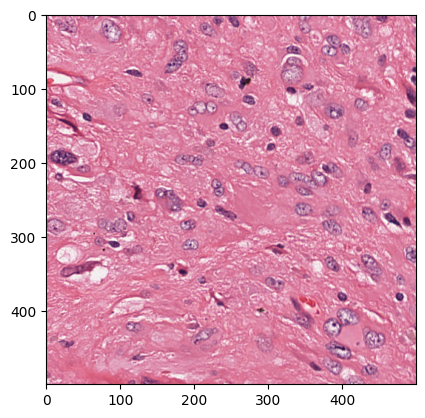

In [35]:
plt.imshow(data_iterator[0])

In [36]:
resolution = (512, 512)
num_channels = 1
batch_size = 2
num_slots = 10
num_iterations = 3

In [37]:
inputs = tf.keras.Input(shape=(512, 512, 1), batch_size=2)
print(inputs.shape)

(2, 512, 512, 1)


In [38]:
outputs = SlotAttentionAutoEncoder(resolution, num_slots, num_iterations)(inputs)
print(outputs)

(<KerasTensor: shape=(2, 512, 512, 1) dtype=float32 (created by layer 'slot_attention_auto_encoder')>, <KerasTensor: shape=(2, 10, 512, 512, 1) dtype=float32 (created by layer 'slot_attention_auto_encoder')>, <KerasTensor: shape=(2, 10, 512, 512, 1) dtype=float32 (created by layer 'slot_attention_auto_encoder')>, <KerasTensor: shape=(2, 10, 64) dtype=float32 (created by layer 'slot_attention_auto_encoder')>)


In [39]:
# test_model = build_model((512,512), 50, 5, 3, model_type="object_discovery")
test_model = SlotAttentionAutoEncoder(resolution, num_slots, num_iterations)
test_model.build(input_shape = inputs.shape)
test_model.summary() # 250 = 50 * 5(number of slots)

Model: "slot_attention_auto_encoder_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_cnn (Sequential)    (2, 512, 512, 64)         309056    
                                                                 
 decoder_cnn (Sequential)    (20, 512, 512, 2)         515522    
                                                                 
 soft_position_embed_2 (Soft  multiple                 320       
 PositionEmbed)                                                  
                                                                 
 soft_position_embed_3 (Soft  multiple                 320       
 PositionEmbed)                                                  
                                                                 
 layer_normalization_4 (Laye  multiple                 128       
 rNormalization)                                                 
                                     

In [41]:
resolution = (512,512)
num_slots = 5
num_iterations = 3

encoder_cnn = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, strides=2, kernel_size=5, padding="SAME", activation="relu"),
    # kernel_size: An integer or tuple/list of 2 integers, specifying the height and width of the 2D convolution window. 
    # Can be a single integer to specify the same value for all spatial dimensions.
    tf.keras.layers.Conv2D(64, strides=2, kernel_size=5, padding="SAME", activation="relu")
    # tf.keras.layers.Conv2D(64, strides=2, kernel_size=5, padding="SAME", activation="relu"),
    # tf.keras.layers.Conv2D(64, strides=2, kernel_size=5, padding="SAME", activation="relu"),
    # tf.keras.layers.Conv2D(64, strides=2, kernel_size=5, padding="SAME", activation="relu"),
    # tf.keras.layers.Conv2D(64, strides=2, kernel_size=5, padding="SAME", activation="relu")
], name="encoder_cnn")

decoder_initial_size = (8, 8)
decoder_cnn = tf.keras.Sequential([
    tf.keras.layers.Conv2DTranspose(64, 5, strides=(2, 2), padding="SAME", activation="relu"), # filters = 64 (number of output channels); kernel_size = 5 (specify the height and width of the 2D convolution window)
    tf.keras.layers.Conv2DTranspose(3, 5, strides=(2, 2), padding="SAME", activation="relu")
    # tf.keras.layers.Conv2DTranspose(64, 5, strides=(2, 2), padding="SAME", activation="relu"),
    # tf.keras.layers.Conv2DTranspose(64, 5, strides=(2, 2), padding="SAME", activation="relu"),
    # tf.keras.layers.Conv2DTranspose(64, 5, strides=(2, 2), padding="SAME", activation="relu"),
    # tf.keras.layers.Conv2DTranspose(3, 5, strides=(2, 2), padding="SAME", activation=None)
], name="decoder_cnn")

# strides : (x_stride, y_stride, channel_stride)

encoder_pos = SoftPositionEmbed(64, resolution)
decoder_pos = SoftPositionEmbed(64, decoder_initial_size)

layer_norm = tf.keras.layers.LayerNormalization()
mlp = tf.keras.Sequential([
    layers.Dense(64, activation="relu"),
    layers.Dense(64)
], name="feedforward")

slot_attention = SlotAttention(num_iterations=num_iterations, num_slots=num_slots, slot_size=64, mlp_hidden_size=128)

In [42]:
# `image` has shape: [batch_size, width, height, num_channels].

# Convolutional encoder with position embedding.
inputs = tf.keras.Input(shape=(512, 512, 3))
x = encoder_cnn(inputs)  # CNN Backbone.
# x = encoder_pos(x)  # Position embedding
# x = spatial_flatten(x)  # Flatten spatial dimensions (treat image as set).
# print("shape after spatial_flatten:")
# print(x.shape) # (None, 262144, 64); 262144 = 512 * 512 

x = mlp(layer_norm(x))  # Feedforward network on set.
# `x` has shape: [batch_size, width*height, input_size(64)].

# Slot Attention module.
# slots = slot_attention(x)
# `slots` has shape: [batch_size, num_slots, slot_size].
# print("this is shape of slots:")
# print(slots.shape) # (None, 5, 64)

# Spatial broadcast decoder.
# x = spatial_broadcast(slots, decoder_initial_size)
# print("shape after spatial_broadcast:") 
# print(x.shape) # (None, 8, 8, 64)

# `x` has shape: [batch_size*num_slots, width_init, height_init, slot_size].
# x = decoder_pos(x)
x = decoder_cnn(x)
# `x` has shape: [batch_size*num_slots, width, height, num_channels+1].

# Undo combination of slot and batch dimension; split alpha masks.
# recons, masks = unstack_and_split(x, batch_size=50)
# `recons` has shape: [batch_size, num_slots, width, height, num_channels].
# `masks` has shape: [batch_size, num_slots, width, height, 1].

# Normalize alpha masks over slots.
# masks = tf.nn.softmax(masks, axis=1)
# recon_combined = tf.reduce_sum(recons * masks, axis=1)  # Recombine image.
# `recon_combined` has shape: [batch_size, width, height, num_channels].

# outputs = recon_combined, recons, masks, slots
outputs = x
slot_attention_ae = tf.keras.Model(inputs = inputs, outputs = outputs, name="Slot_Attention_AutoEnconder")
slot_attention_ae.summary()

Model: "Slot_Attention_AutoEnconder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 512, 512, 3)]     0         
                                                                 
 encoder_cnn (Sequential)    (None, 128, 128, 64)      107328    
                                                                 
 layer_normalization_12 (Lay  (None, 128, 128, 64)     128       
 erNormalization)                                                
                                                                 
 feedforward (Sequential)    (None, 128, 128, 64)      8320      
                                                                 
 decoder_cnn (Sequential)    (None, 512, 512, 3)       107267    
                                                                 
Total params: 223,043
Trainable params: 223,043
Non-trainable params: 0
_________________________________

In [43]:
'''
def renormalize(x):
  """Renormalize from [-1, 1] to [0, 1]."""
  return x / 2. + 0.5
'''

def get_prediction(model, batch):
  recon_combined, recons, masks, slots = model(batch)
  image = batch
  return image, recon_combined, recons, masks, slots

In [44]:
# data_iterator[0:1000] = tf.convert_to_tensor(data_iterator[0:1000])
# data_iterator[1000:2000] = tf.convert_to_tensor(data_iterator[1000:2000])
# data_iterator[2000:3000] = tf.convert_to_tensor(data_iterator[2000:3000])
# data_iterator[3000:4000] = tf.convert_to_tensor(data_iterator[3000:4000])
# data_iterator[4000:5230] = tf.convert_to_tensor(data_iterator[4000:5230])

In [45]:
# data_iterator[0:1000] = tf.cast(data_iterator[0:1000], tf.float32)
# data_iterator[1000:2000] = tf.cast(data_iterator[1000:2000], tf.float32)
# data_iterator[2000:3000] = tf.cast(data_iterator[2000:3000], tf.float32)
# data_iterator[3000:4000] = tf.cast(data_iterator[3000:4000], tf.float32)
# data_iterator[4000:5230] = tf.cast(data_iterator[4000:5230], tf.float32)

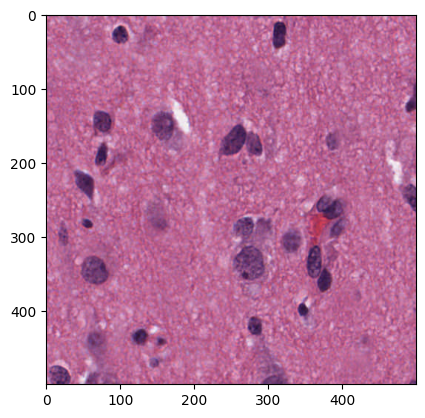

In [46]:
plt.imshow(data_iterator[5])

In [47]:
data_iterator[5]

array([[[186, 103, 143, 255],
        [173,  93, 142, 255],
        [175,  93, 149, 255],
        ...,
        [190, 106, 163, 255],
        [203, 111, 160, 255],
        [188, 105, 158, 255]],

       [[182, 103, 160, 255],
        [157,  89, 159, 255],
        [181,  95, 157, 255],
        ...,
        [186, 110, 171, 255],
        [203, 121, 168, 255],
        [188, 113, 164, 255]],

       [[191, 109, 151, 255],
        [192, 107, 152, 255],
        [196, 115, 164, 255],
        ...,
        [195, 124, 165, 255],
        [192, 105, 156, 255],
        [202, 113, 166, 255]],

       ...,

       [[179,  84, 125, 255],
        [172,  97, 133, 255],
        [180, 116, 148, 255],
        ...,
        [106,  54, 116, 255],
        [ 70,  34,  95, 255],
        [ 78,  41, 100, 255]],

       [[193,  90, 118, 255],
        [199,  94, 118, 255],
        [200, 101, 139, 255],
        ...,
        [100,  53, 121, 255],
        [101,  60, 124, 255],
        [ 89,  54, 121, 255]],

       [[199

In [48]:
print(final.shape)

(1521, 512, 512, 1)


In [49]:
# Hyperparameters of the model.
batch_size = 5
num_slots = 10
num_iterations = 10 # Number of iterations in Slot Attention
learning_rate = 0.001
num_train_steps = 304
epoch_size = 20
tf.random.set_seed(377)
resolution = (512, 512)

In [50]:
model = build_model(resolution, batch_size, num_slots, num_iterations, model_type="object_discovery")

In [51]:
print(model.trainable_variables)

[<tf.Variable 'conv2d_12/kernel:0' shape=(5, 5, 1, 64) dtype=float32, numpy=
array([[[[ 0.00951145,  0.03680964, -0.05827393, ..., -0.04327091,
          -0.03352224, -0.04497719]],

        [[ 0.01316848,  0.0580372 , -0.04064626, ...,  0.01624632,
           0.00660599, -0.04240338]],

        [[ 0.01912422,  0.00580491, -0.05794037, ..., -0.05133301,
           0.01166099, -0.00105361]],

        [[ 0.05898474,  0.04633767,  0.02121318, ..., -0.04677526,
          -0.00568753, -0.02503241]],

        [[-0.0445993 , -0.03907128, -0.0234079 , ..., -0.05401478,
           0.0352281 , -0.03648903]]],


       [[[ 0.03859845, -0.04594721, -0.05805901, ...,  0.0605486 ,
           0.06050074, -0.02532967]],

        [[-0.05308711,  0.01401563,  0.0502171 , ..., -0.02117986,
          -0.01481917,  0.00144685]],

        [[ 0.05301861, -0.02024931, -0.00383588, ...,  0.03144825,
           0.04760631,  0.05001095]],

        [[ 0.04979328,  0.05391791,  0.00106159, ..., -0.01758408,
      

In [52]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(5, 512, 512, 1)]        0         
                                                                 
 slot_attention_auto_encoder  ((5, 512, 512, 1),       888002    
 _2 (SlotAttentionAutoEncode   (5, 10, 512, 512, 1),             
 r)                           (5, 10, 512, 512, 1),              
                              (5, 10, 64))                       
                                                                 
Total params: 888,002
Trainable params: 888,002
Non-trainable params: 0
_________________________________________________________________


In [56]:
data_augmentation = tf.keras.Sequential([
     layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
     layers.experimental.preprocessing.RandomRotation(0.7)])

In [57]:
# plt.imshow(data_iterator[0])

In [58]:
aug_img = []
for j in range(data_iterator.shape[0]):
    for i in range(10):
      augmented_image = data_augmentation(data_iterator[j])
      aug_img.append(augmented_image)

aug_img = np.array(aug_img)
print(aug_img.shape)

(640,)


In [59]:
data_iterator = aug_img
data_iterator.shape

(640,)

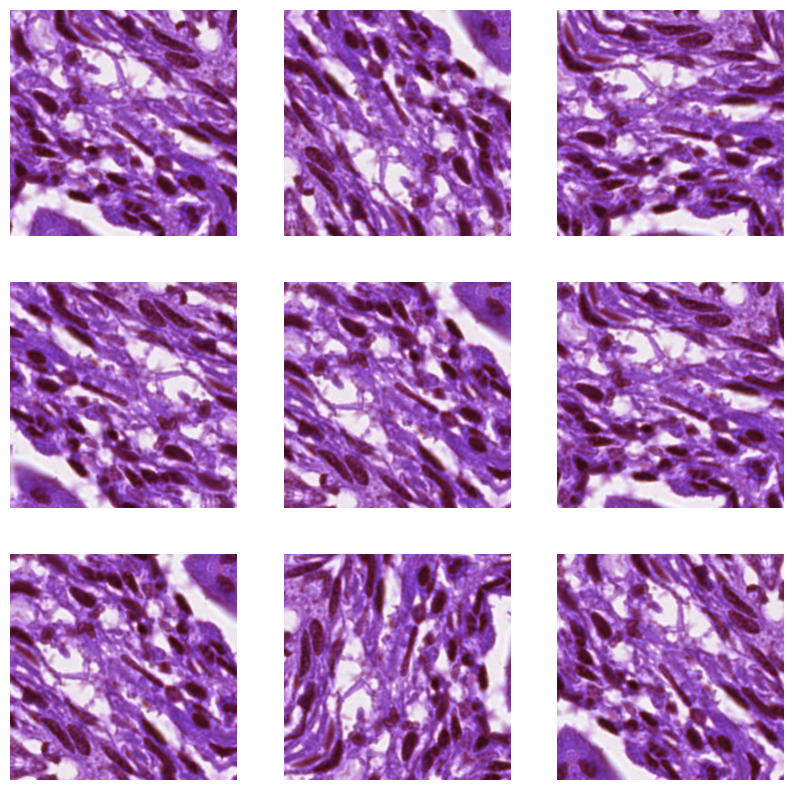

In [253]:
plt.figure(figsize=(10, 10))
for l in range(9):
    ax = plt.subplot(3, 3, l + 1)
    plt.imshow(aug_img[l])
    plt.axis("off")

In [47]:
"""Training loop for object discovery with Slot Attention."""

# We use `tf.function` compilation to speed up execution. For debugging,
# consider commenting out the `@tf.function` decorator.




def l2_loss(prediction, target):
    
  # print(f'this is the shape of prediction: {prediction.shape}')
  # print(f'this is the shape of target: {target.shape}')

  return tf.reduce_mean(tf.math.squared_difference(prediction, target))



def train_step(batch, model, optimizer):
  """Perform a single training step."""

  # Get the prediction of the models and compute the loss.
  with tf.GradientTape() as tape:
    # print(f'this is batch.shape: {batch.shape}') # (50, 512, 512, 3)
    # print("this is batch[0]")
    # tf.print(batch[0])

    preds = model(batch, training=True)
    recon_combined, recons, masks, slots = preds
    
    # print(f'this is recon_combined.shape: {recon_combined.shape}') # (10, 512, 512, 3)
    # print("this is recon_combined:")
    # tf.print(recon_combined)
    # plt.imshow(recon_combined[0])
    # plt.show() 

    # print(f'this is batch.shape: {batch.shape}') # 
    # print("this is batch:")
    # tf.print(batch)
    # plt.imshow(batch[0])
    # plt.show() 
    

    loss_value = l2_loss(recon_combined, batch)
    del recons, masks, slots  # Unused.

  # Get and apply gradients.
  # print('this is loss_value:')
  # tf.print(loss_value)

  # print("this is model.trainable_variables:")
  # print(model.trainable_variables)

  gradients = tape.gradient(loss_value, model.trainable_variables)
  # print("this is gradients:")
  # tf.print(gradients)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))   
  return loss_value


average_loss = []



# Build dataset iterators, optimizers and model.
optimizer = tf.keras.optimizers.Adam(learning_rate)
                                  
  
for l in range(epoch_size):
    print(l)
    loss = []

    # new_index = np.arange(np.shape(data_iterator)[0])
    # new_shuffle_index = tf.random.shuffle(new_index)
    # new_train_inputs = tf.gather(data_iterator, new_shuffle_index)
    new_train_inputs = final
    


    for i in range(num_train_steps):
        # print(i)
        start = i * batch_size
        end = (i + 1) * batch_size
        batch = new_train_inputs[start:end]
        # print(f'this is batch.shape: {batch.shape}')

        # print("this is batch[0]:")
        # print(batch[0])
        # plt.imshow(batch[0])
        # plt.show() 
        batch = tf.convert_to_tensor(batch)
        batch = tf.cast(batch, tf.float32)
        # print(batch[0])
    
        loss_value = train_step(batch, model, optimizer)
        # print(loss_value)

        loss.append(loss_value)
        # print("done!")
    
    loss = np.array(loss)
    average_loss_epoch = statistics.mean(loss)
    print(f'this is average_loss_epoch: {average_loss_epoch}')
    average_loss.append(average_loss_epoch)

  
print("this is average_loss:")
print(average_loss)
print("Done Training !!!")

0


2023-02-13 07:07:56.386015: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8200


this is average_loss_epoch: 0.24215902388095856
1
this is average_loss_epoch: 0.009461459703743458
2
this is average_loss_epoch: 0.008004088886082172
3
this is average_loss_epoch: 0.007267390377819538
4
this is average_loss_epoch: 0.006566965952515602
5
this is average_loss_epoch: 0.006516637746244669
6
this is average_loss_epoch: 0.006349199917167425
7
this is average_loss_epoch: 0.006301425397396088
8
this is average_loss_epoch: 0.0061948103830218315
9
this is average_loss_epoch: 0.006060407962650061
10
this is average_loss_epoch: 0.006142515689134598
11
this is average_loss_epoch: 0.006219814065843821
12
this is average_loss_epoch: 0.006281384266912937
13
this is average_loss_epoch: 0.006160858552902937
14
this is average_loss_epoch: 0.005981525871902704
15
this is average_loss_epoch: 0.005986396688967943
16
this is average_loss_epoch: 0.00604418246075511
17
this is average_loss_epoch: 0.007712546736001968
18
this is average_loss_epoch: 0.008168763481080532
19
this is average_loss_e

Text(0, 0.5, 'loss')

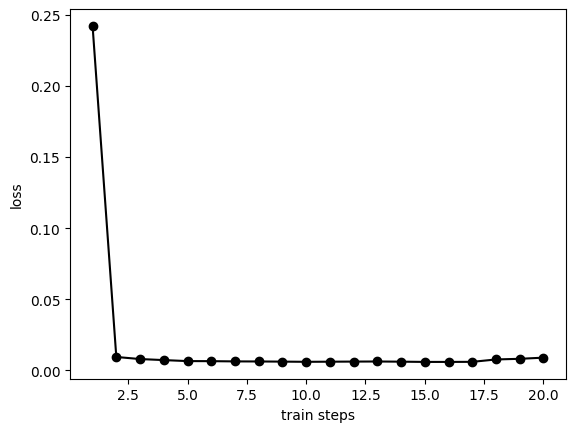

In [48]:
y = np.array(average_loss)
x = np.arange(20)
x = x+1
plt.plot(x, y, '-ok', color='black')
plt.xlabel("train steps")
plt.ylabel("loss")

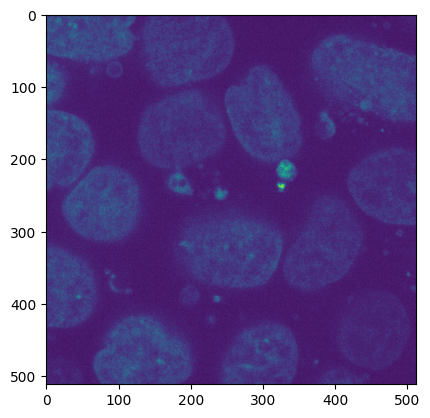

In [68]:
plt.imshow(final[700])

In [70]:
test = np.expand_dims(final[700], axis = 0)
test.shape

(1, 512, 512, 1)

In [71]:
recon_combined, recons, masks, slots = model(test)

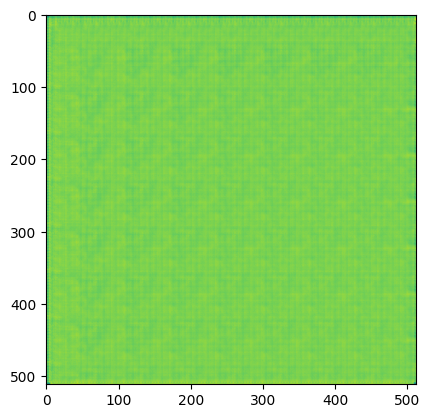

In [72]:
plt.imshow(recon_combined[0])

Text(0.5, 0.98, 'Number of Slots = 10; Iteration = 10; Epoch Size = 20')

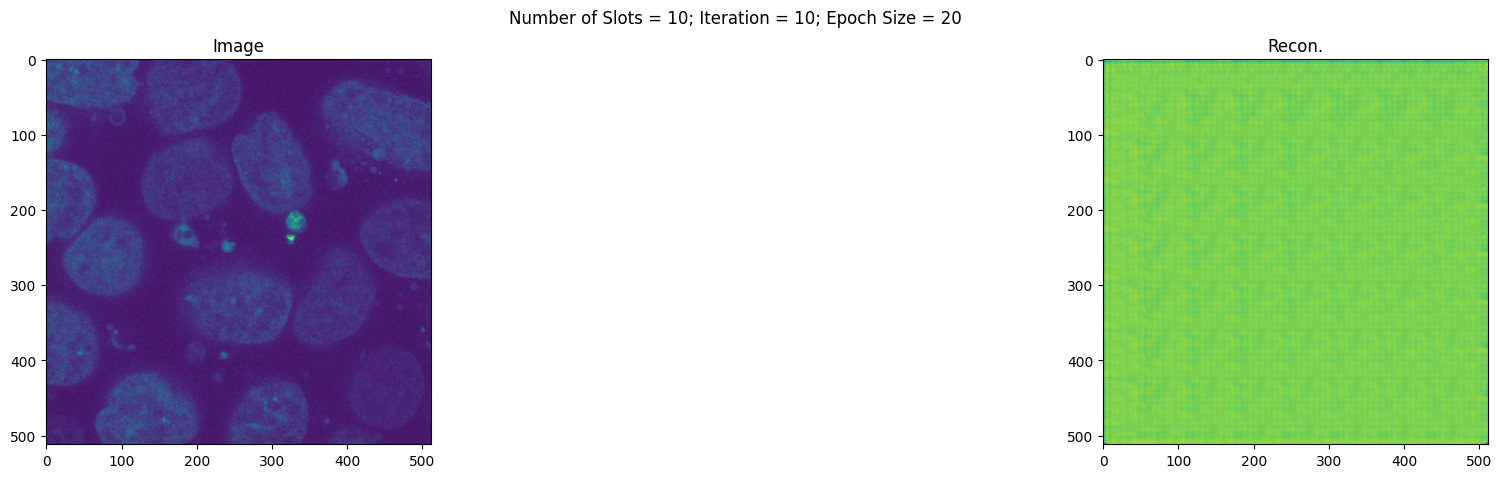

In [75]:
# Visualize.
num_slots = len(masks)
fig, ax = plt.subplots(1, 2, figsize=(25, 5))
ax[0].imshow(test[0])
ax[0].set_title('Image')
ax[1].imshow(recon_combined[0])
ax[1].set_title('Recon.')
"""
for i in range(num_slots):
    ax[i + 2].imshow(recons[i] * masks[i] + (1 - masks[i]))
    ax[i + 2].set_title('Slot %s' % str(i + 1))
for i in range(len(ax)):
    ax[i].grid(False)
    ax[i].axis('off')  
"""
plt.suptitle('Number of Slots = 10; Iteration = 10; Epoch Size = 20')

In [136]:
test = data_iterator[0]
test = np.expand_dims(test, axis=0)

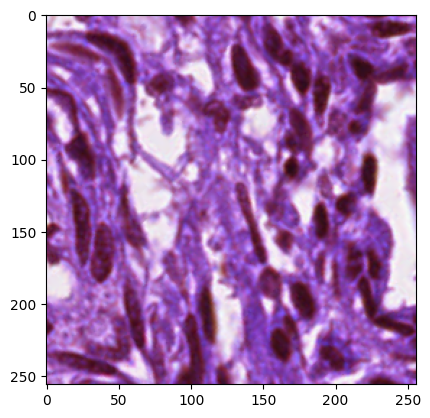

In [137]:
plt.imshow(data_iterator[0])

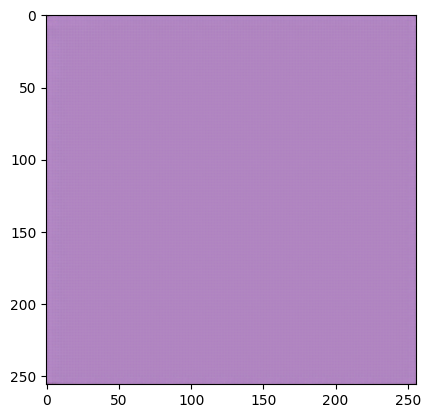

In [138]:
plt.imshow(model(test)[0])

Text(0.5, 1.0, 'Iteration = 100; Epoch size = 20; Output only RGB channels; One slot')

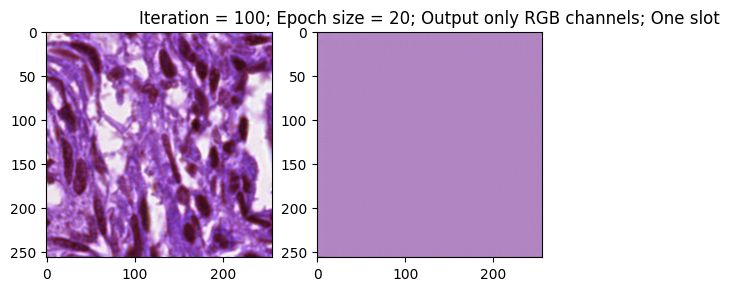

In [145]:
plt.subplot(1,2,1)
plt.imshow(data_iterator[0])
plt.subplot(1,2,2)
plt.imshow(model(test)[0])
plt.title('Iteration = 100; Epoch size = 20; Output only RGB channels; One slot')